## SMS Spam Detection with Naive Bayes Classifier

**Dataset and Resources**

* SMS Spam Collection Dataset: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

<b>Naive Bayes Classifier model design: </b><br>

Initial steps: 

1. Load dataset into dataframe.
2. Split data into 80% train and 20% test set.
<br>
<br>

Training: 

1. Load train data into dataframe.
2. Preprocess and tokenize train data, including removing stopwords.
3. Group ham and spam class into two individual dataframe.
4. Calculate the total number of documents in ham class $N_{h}$ and spam class $N_{s}$.
5. Calculate the probability of ham class $\widehat{P}(H)$ and spam class $\widehat{P}(S)$.

$$ \widehat{P}(H) =  \frac{N_{h}}{N_{h} + N_{s}} $$
$$ \widehat{P}(S) =  \frac{N_{s}}{N_{h} + N_{s}} $$

5. Create a vocabulary vector from the train data. 
6. Create the bag of word matrix / tfidf matrix for ham and spam.
7. Calculate the frequency / total tfidf for each vocab in each class and the probability of the word given its class. Example for BoW:

$$ n_{h}(w) = \text{number of documents in class ham with word w} $$ 
$$ n_{s}(w) = \text{number of documents in class spam with word w} $$
$$ \widehat{P}(w|H) =  \frac{n_{h}(w)}{N_{h}} $$
$$ \widehat{P}(w|S) =  \frac{n_{s}(w)}{N_{s}} $$

<br>
<br>

Testing: 

For Bag of Word method:

1. Load test data into dataframe.
2. Preprocess and tokenize test data, including removing stopwords.
3. Create bag of words matrix for test data.
4. Calculate probability of each class k given bow matrix of test data using Bayes theorem [1]. Example for BoW:

$$ P(C_{k}|b) = P(b|C_{k})P(C_{k}) $$
$$            = P(C_{k})\prod_{i=1}^{V} [b_{i} P(w_{i}|C_{k}) + (1-b_{i})(1-P(w_{i}|C_{k}))] $$

5. The class with the larger probability will be the predicted class.
6. Evaluate model's performance with accuracy score.

For TF-IDF method:

1. Load test data into dataframe.
2. Preprocess and tokenize test data.
3. Calculate tf-idf matrix [2] for test data.

$$ TF = \frac{\text{Number of times word appears in the document}}{\text{Total number of words in the document}} $$

$$ DF = \text{Number of documents in the corpus that contains the word} $$

$$ IDF = \log{(\frac{\text{Total number of documents}}{DF + 1}) + 1} $$

$$ TFIDF = TF * IDF $$

4. Calculate probability of each class k given tf-idf matrix of test data using Bayes theorem.
5. The class with the larger probability will be the predicted class.
6. Evaluate model's performance with accuracy score.
<br>
<br>

Evaluation metric:
1. Accuracy score 
2. F1 score

Implementation

In [1]:
import pandas as pd
import numpy as np
import string
import math
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cassa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
''' 
load file and convert to dataframe and new list of only text content
'''
def load_file(filename: str):
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read().split("\n")
        new_df = []
        for line in text:
            temp = line.split("\t")
            # ignore empty lines
            if len(temp) > 1:
                new_df.append(temp)

    dataframe = pd.DataFrame(new_df, columns=['label', 'content'])
    return dataframe


''' 
tokenize text 
'''
def split_token(line: list[str]):
    cleaned_text = []
    for i in line:
        # ignore any empty sentences
        if i == "":
            continue
        else:
            # convert words to lower case to normalize
            # remove stopwords
            # split sentence into tokens
            sentence = i.lower().split(" ")
            sentence = [word for word in sentence if word not in stopwords.words('english')]
            if sentence:
                cleaned_text.append(sentence)
                
    return cleaned_text


''' 
pre-process data 
'''
def process_data(line: list[list[str]]):
    for s in range(len(line)):
        clean = []
        for word in line[s]:
            # filter each word to ignore punctuations
            new = ''.join(char for char in word if char not in string.punctuation)
            clean.append(new)
        # ignore empty strings
        clean = [i for i in clean if i]
        line[s] = clean
        
    return line


''' 
create vocab dictionary 
'''
def make_vocab(data: list[str]):
    vocab = []
    for sentence in data:
        for word in sentence:
            if word in vocab:
                continue
            else:
                vocab.append(word)
                
    return vocab


'''
create bag of words vector 
'''
def make_bag_of_words(data: list[list[str]], vocab: list):  
    bow = []
    for line in data:
        curr_bow = [1 if i in line else 0 for i in vocab]
        bow.append(curr_bow)
    
    return np.array(bow) 


'''
calculate DF
'''
def calc_df(df, vocab, column=None):
    df_dict = {}
    for word in vocab:
        count = df[df[column].str.contains(word)].shape[0]
        df_dict[word] = count
        
    return df_dict


'''
calculate TF-IDF
'''
def calc_tfidf(word, doc, total_doc, df_dict):
    tf = doc.count(word) / len(doc)
    df = df_dict[word]
    # smoothing to avoid log 0
    idf = np.log(total_doc / (df + 1)) + 1
    return tf * idf


'''
create TF-IDF matrix
'''
def get_tfidf_matrix(vocab, data, df_dict):
    tfidf_matrix = []
    total_doc = len(data)
    for doc in data:
        if len(doc) == 0:
            vector = [0 for i in range(len(vocab))]
        else:
            vector = [calc_tfidf(word, doc, total_doc, df_dict) for word in vocab]
        tfidf_matrix.append(vector)
        
    return np.array(tfidf_matrix)
    
    
'''
Train the model
'''
def train(n1, n2, vocab, bow1=None, bow2=None, tfidf1=None, tfidf2=None, tfidf_method=False):
    if tfidf_method is False:
        # get total count of each vocab in each class
        n_ham_w = np.sum(bow1, axis=0) + 1
        n_spam_w = np.sum(bow2, axis=0) + 1
        
        # get probability of each vocab in each class
        p_w_ham = np.array(n_ham_w) / n1
        p_w_spam = np.array(n_spam_w) / n2
    
    if tfidf_method is True:
        # get total tfidf of each vocab in each class
        n_ham_w = np.sum(tfidf1, axis=0) + 1
        total_nham = int(np.sum(n_ham_w))
        n_spam_w = np.sum(tfidf2, axis=0) + 1
        total_nspam = int(np.sum(n_spam_w))
        
        # get probability of each vocab in each class
        p_w_ham = np.array(n_ham_w) / (total_nham + len(vocab))
        p_w_spam = np.array(n_spam_w) / (total_nspam + len(vocab))
        
    # arrange into dataframe
    ham_prob_df = pd.DataFrame(np.vstack([vocab, n_ham_w, p_w_ham]).T, columns=['word', 'n_ham(word)', 'P(word|ham)'])
    spam_prob_df = pd.DataFrame(np.vstack([vocab, n_spam_w, p_w_spam]).T, columns=['word', 'n_spam(word)', 'P(word|spam)'])

    # merge train ham and spam dataframe
    merged_df = ham_prob_df.merge(spam_prob_df, on='word', how='outer')
    
    # rearrange columns
    merged_df = merged_df[['word', 'n_ham(word)', 'P(word|ham)', 'n_spam(word)', 'P(word|spam)']]

    return merged_df


'''
Test the model 
'''
def test(data, vocab, merged, p_ham, p_spam, tfidf_method=False, df_dict=None):
    # pre-process test data
    data = data['X_test'].to_list()
    data = split_token(data)
    data = process_data(data)
    
    p_w_ham = merged['P(word|ham)'].astype(float).to_numpy()
    p_w_spam = merged['P(word|spam)'].astype(float).to_numpy()
    
    # Bag of Word method
    if tfidf_method is False:
        # create bag of words
        test_bow = make_bag_of_words(data, vocab)
        
        # calculate probability of sentence being classified as ham or spam
        curr_ham_prob = np.sum(np.log2(test_bow * p_w_ham + (1 - test_bow) * (1 - p_w_ham)), axis=1)
        curr_spam_prob = np.sum(np.log2(test_bow * p_w_spam + (1 - test_bow) * (1 - p_w_spam)), axis=1)
        
    # TF-IDF method
    if tfidf_method is True:
        # create tf-idf matrix
        tfidf_matrix = get_tfidf_matrix(vocab, data, df_dict)
    
        # calculate probability of sentence being classified as ham or spam
        curr_ham_prob = np.sum(tfidf_matrix * np.log2(p_w_ham), axis=1)
        curr_spam_prob = np.sum(tfidf_matrix * np.log2(p_w_spam), axis=1)
    
    ham_prob = np.log2(p_ham) + curr_ham_prob
    spam_prob = np.log2(p_spam) + curr_spam_prob
    
    # predict if ham or spam
    predicted = np.where(ham_prob > spam_prob, "ham", "spam").tolist()

    return predicted


'''
Evaluate Accuracy Score 
'''
def evaluate(data):
    total_rows = data.shape[0]
    correct_predictions = 0
    
    true_labels = data['y_test']
    predicted_labels = data['predicted']
    
    for _, row in data.iterrows():
        if row['y_test'] == row['predicted']:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_rows
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    cm = confusion_matrix(true_labels, predicted_labels)
    
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy, f1
   

### Load data

In [3]:
# load original dataframe

df = load_file("SMSSpamCollection")
df

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [4]:
# check if labels are balanced

df['label'].value_counts()

label
ham     4827
spam     747
Name: count, dtype: int64

In [5]:
# undersample ham class

label_ham, label_spam = df.label.value_counts()
l0 = df[df['label'] == 'ham']
l1 = df[df['label'] == 'spam']

undersample_ham = l0.sample(n=1500, replace=True)

balanced_df = pd.concat([undersample_ham, l1], axis=0, ignore_index=True)
balanced_df = shuffle(balanced_df)
balanced_df['label'].value_counts()

label
ham     1500
spam     747
Name: count, dtype: int64

### Train Test split

In [6]:
# split to 80% train and 20% test data

X = balanced_df.iloc[:, 1]
y = balanced_df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Training

In [7]:
# load train dataframe

train_df = pd.DataFrame({"y_train": y_train, "X_train": X_train})
train_df

,y_train,X_train
1262,ham,Smile in Pleasure Smile in Pain Smile when tro...
2205,spam,Had your mobile 11mths ? Update for FREE to Or...
1958,spam,Had your mobile 10 mths? Update to latest Oran...
259,ham,"Jay wants to work out first, how's 4 sound?"
306,ham,It's é only $140 ard...É rest all ard $180 at ...
...,...,...
1573,spam,Boltblue tones for 150p Reply POLY# or MONO# e...
1816,spam,Had your mobile 11mths ? Update for FREE to Or...
1807,spam,You have WON a guaranteed £1000 cash or a £200...
1760,spam,You have WON a guaranteed £1000 cash or a £200...


In [8]:
# split to ham and spam dataframe

ham_df = train_df[train_df["y_train"]=="ham"]
n_ham = ham_df.shape[0]
p_ham = float(n_ham / train_df.shape[0])

spam_df = train_df[train_df["y_train"]=="spam"]
n_spam = spam_df.shape[0]
p_spam = float(n_spam / train_df.shape[0])

In [9]:
# ham
# process data in ham
ham_content = ham_df['X_train'].to_list()
ham_content = split_token(ham_content)
ham_content = process_data(ham_content)

# spam
# process data in ham
spam_content = spam_df['X_train'].to_list()
spam_content = split_token(spam_content)
spam_content = process_data(spam_content)

# get train vocab
train_content = train_df['X_train'].to_list()
train_content = split_token(train_content)
train_content = process_data(train_content)

train_vocab = make_vocab(ham_content)

### Bag of Words method

In [10]:
# create bag of words for ham class
ham_bow = make_bag_of_words(ham_content, train_vocab)

# create bag of words for spam class
spam_bow = make_bag_of_words(spam_content, train_vocab)

In [11]:
merged_df_bow = train(n_ham, n_spam, train_vocab, bow1=ham_bow, bow2=spam_bow, tfidf_method=False)

In [12]:
merged_df_bow

,word,n_ham(word),P(word|ham),n_spam(word),P(word|spam)
0,smile,12,0.010025062656641603,1,0.0016666666666666668
1,pleasure,3,0.002506265664160401,1,0.0016666666666666668
2,pain,5,0.004177109440267335,1,0.0016666666666666668
3,trouble,5,0.004177109440267335,1,0.0016666666666666668
4,pours,2,0.001670843776106934,1,0.0016666666666666668
...,...,...,...,...,...
3213,step,2,0.001670843776106934,1,0.0016666666666666668
3214,foward,2,0.001670843776106934,1,0.0016666666666666668
3215,ruin,2,0.001670843776106934,1,0.0016666666666666668
3216,how,2,0.001670843776106934,1,0.0016666666666666668


### TFIDF method

In [13]:
# create tfidf for ham class
ham_df_dict = calc_df(ham_df, train_vocab, column="X_train")
ham_tfidf = get_tfidf_matrix(train_vocab, ham_content, ham_df_dict)

# create tfidf for spam class
spam_df_dict = calc_df(spam_df, train_vocab, column="X_train")
spam_tfidf = get_tfidf_matrix(train_vocab, spam_content, spam_df_dict)

In [14]:
merged_df_tfidf = train(n_ham, n_spam, train_vocab, tfidf1=ham_tfidf, tfidf2=spam_tfidf, tfidf_method=True)

In [15]:
merged_df_tfidf

,word,n_ham(word),P(word|ham),n_spam(word),P(word|spam)
0,smile,5.546982400865587,0.000422820519922676,1.0,0.00013044612575006522
1,pleasure,2.0915582013092324,0.0001594296974852681,1.0,0.00013044612575006522
2,pain,3.707815097371445,0.000282629399906353,1.0,0.00013044612575006522
3,trouble,2.371458499030795,0.0001807651878215409,1.0,0.00013044612575006522
4,pours,1.3521155488094299,0.00010306544315949614,1.0,0.00013044612575006522
...,...,...,...,...,...
3213,step,1.6722205931816387,0.00012746555325723291,1.0,0.00013044612575006522
3214,foward,1.3361102965908194,0.0001018454376546093,1.0,0.00013044612575006522
3215,ruin,1.3361102965908194,0.0001018454376546093,1.0,0.00013044612575006522
3216,how,1.5244691759309184,0.00011620315389365945,1.0,0.00013044612575006522


### Testing 

In [16]:
# load test dataframe

test_df = pd.DataFrame({"y_test": y_test, "X_test": X_test})
test_df

,y_test,X_test
594,ham,It is a good thing I'm now getting the connect...
954,ham,Babes I think I got ur brolly I left it in Eng...
138,ham,* Was thinking about chuckin ur red green n bl...
408,ham,Tell me whos this pls:-)
2132,spam,URGENT! Your Mobile No 07808726822 was awarded...
...,...,...
995,ham,Nope wif my sis lor... Aft bathing my dog then...
2246,spam,This is the 2nd time we have tried 2 contact u...
2121,spam,Well done ENGLAND! Get the official poly ringt...
2042,spam,"Thanks for your ringtone order, reference numb..."


#### Bag of Words method

In [17]:
# predict test data

predicted_res = test(test_df, train_vocab, merged_df_bow, p_ham, p_spam, tfidf_method=False)

res_bow_df = test_df.assign(predicted=predicted_res)
res_bow_df

,y_test,X_test,predicted
594,ham,It is a good thing I'm now getting the connect...,ham
954,ham,Babes I think I got ur brolly I left it in Eng...,ham
138,ham,* Was thinking about chuckin ur red green n bl...,ham
408,ham,Tell me whos this pls:-),ham
2132,spam,URGENT! Your Mobile No 07808726822 was awarded...,spam
...,...,...,...
995,ham,Nope wif my sis lor... Aft bathing my dog then...,ham
2246,spam,This is the 2nd time we have tried 2 contact u...,spam
2121,spam,Well done ENGLAND! Get the official poly ringt...,spam
2042,spam,"Thanks for your ringtone order, reference numb...",spam


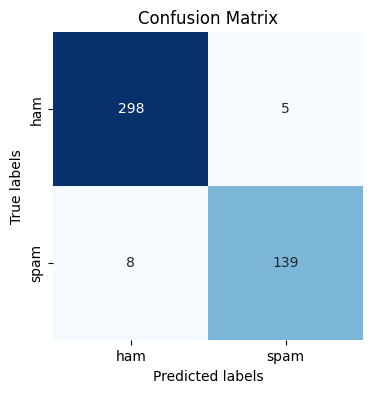

Test Accuracy using Bag of Words method: 0.9711111111111111
F1 score using Bag of Words method: 0.9710333542114558


In [18]:
# calculate predicted test accuracy

test_acc_bow, f1_bow = evaluate(res_bow_df)
print(f'Test Accuracy using Bag of Words method: {test_acc_bow}')
print(f'F1 score using Bag of Words method: {f1_bow}')

#### Test with Bag of Words and TF-IDF

In [19]:
df_records = calc_df(test_df, train_vocab, column='X_test')

In [20]:
# predict test data

predicted_res1 = test(test_df, train_vocab, merged_df_tfidf, p_ham, p_spam, tfidf_method=True, df_dict=df_records)

res_tfidf_df = test_df.assign(predicted=predicted_res1)
res_tfidf_df

,y_test,X_test,predicted
594,ham,It is a good thing I'm now getting the connect...,ham
954,ham,Babes I think I got ur brolly I left it in Eng...,ham
138,ham,* Was thinking about chuckin ur red green n bl...,ham
408,ham,Tell me whos this pls:-),ham
2132,spam,URGENT! Your Mobile No 07808726822 was awarded...,spam
...,...,...,...
995,ham,Nope wif my sis lor... Aft bathing my dog then...,ham
2246,spam,This is the 2nd time we have tried 2 contact u...,spam
2121,spam,Well done ENGLAND! Get the official poly ringt...,spam
2042,spam,"Thanks for your ringtone order, reference numb...",spam


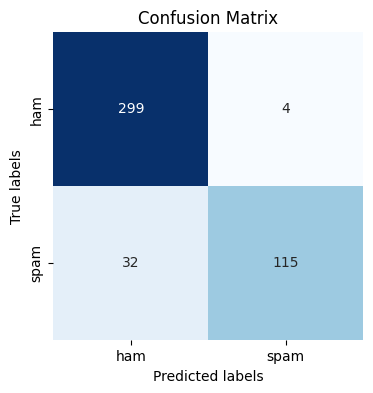

Test Accuracy using Bag of Words and TF-IDF method: 0.92
F1 score using Bag of Words and TF-IDF method: 0.9175560351984061


In [21]:
# calculate predicted test accuracy

test_acc_tfidf, f1_tfidf = evaluate(res_tfidf_df)
print(f'Test Accuracy using Bag of Words and TF-IDF method: {test_acc_tfidf}')
print(f'F1 score using Bag of Words and TF-IDF method: {f1_tfidf}')

<b>Potential improvements:</b><br>

Improvements can be made to have by including lemmatization in preprocessing, and also generalizing preprocessing stage to accept other languages.

References: <br>

[1] Shimodaira, Hiroshi. 2020. Text Classification using Naive Bayes. Retrieved from https://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn07-notes-nup.pdf <br>
[2] Pradeep. 2023. Understanding TF-IDF in NLP: A Comprehensive Guide. Retrieved from https://medium.com/@er.iit.pradeep09/understanding-tf-idf-in-nlp-a-comprehensive-guide-26707db0cec5
